## Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss

import helper 
from models_stationary import *


current_path = os.getcwd()

random_state = helper.RANDOM_STATE

# Define a context manager to temporarily suppress FutureWarnings
class SuppressFutureWarnings:
    def __enter__(self):
        warnings.filterwarnings('ignore', category=FutureWarning)
    
    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings('default')

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^IRX"]
START_DATE = helper.START_DATE
END_DATE = helper.END_DATE
stock_data = {}
MAs = [5, 10, 20, 50, 100, 200]
for stock in STOCKS: 
    data_path = os.path.join(current_path, "data", f"{stock}_{START_DATE}_{END_DATE}.csv")
    data = pd.read_csv(data_path)
    data['Date'] = pd.to_datetime(data['Date'])
    if stock != "^IRX":
        data['RSI'] = helper.compute_rsi(data['Close'])
        data['rsi_class'] = helper.compute_rsi_class(data)  # Assuming you have this function in helper
        #data['volume_class'] = helper.compute_volume_class(data)  # Add volume analysis
        data = helper.calculate_mas(data, MAs, column_name="Close")
        data['WVAD'] = helper.calculate_wvad(data, period=14)
        data['ROC'] = helper.calculate_roc(data, period=14)
        data['MACD'], data['macd_line'], data['signal_line'] = helper.calculate_macd(data, short_window=12, long_window=26, signal_window=9)
        data['CCI'] =  helper.calculate_cci(data, period=20)
        data['Upper Band'], data['Lower Band'], data['SMA'] = helper.calculate_bollinger_bands(data, window=20, num_std_dev=2)
        data['SMI'] = helper.calculate_smi(data, period=14, signal_period=3)
        data['ATR'] = helper.calculate_atr(data, period=14)
        data[['WVF', 'upperBand', 'rangeHigh', 'WVF_color']] = helper.cm_williams_vix_fix(data['Close'], data['Low'])
        data[['Buy_Signal', 'Sell_Signal', 'BB_Upper', 'BB_Lower']] = helper.bollinger_rsi_strategy(data['Close'])
        data = helper.on_balance_volume(data)
        data = helper.volume_price_trend(data)
        data = helper.money_flow_index(data)
        data = helper.accumulation_distribution(data)
        data = data.dropna()
    stock_data[stock] = data
    print(f"Data fetched for {stock}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^IRX


## Stationarity Check

In [22]:
significance_level = 0.05  
data = stock_data['AAPL']
results = []

for feature in data.columns:
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
print(nonstationary_features_list)
feature_stationarity.sort_values('p-value', ascending=False)

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Open', 'VPT', 'BB_Lower', 'BB_Upper', 'ATR', 'SMA', 'Lower Band', 'Upper Band', 'MA200', 'MA100', 'AD', 'MA20', 'High', 'Low', 'Close', 'MA50', 'Volume', 'MA5', 'Adj Close', 'MA10']


,Feature,Stationarity,p-value
10,MA50,nonstationary,9.859434e-01
30,BB_Upper,nonstationary,9.852933e-01
19,Upper Band,nonstationary,9.696534e-01
8,MA10,nonstationary,9.598414e-01
7,MA5,nonstationary,9.581930e-01
9,MA20,nonstationary,9.568627e-01
21,SMA,nonstationary,9.568627e-01
20,Lower Band,nonstationary,9.550818e-01
1,High,nonstationary,9.442359e-01
2,Low,nonstationary,9.424528e-01


In [23]:
for stock in stock_data: 
    data = stock_data[stock]
    if stock != "^IRX":
        # convert price related features into something stationary
        for feature in helper.PRICE_FEATURES_TO_CONVERT:
            data[feature] = (data[feature] - data['Close']) / data['Close']
        for feature in helper.ORIGINAL_PRICE_FEATURES:
            data[f'{feature}_diff'] = data[feature].pct_change() * 100

        # convert volume related features into something stationary
        data['Volume_MA5'] = data['Volume'].rolling(window=5).mean()
        data['Volume_MA_diff'] = (data['Volume'] - data['Volume_MA5'])/(data['Volume_MA5'])
            
        data = data.dropna()
    stock_data[stock] = data

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
data = stock_data['AAPL']
results = []

for feature in data.columns.drop(helper.ORIGINAL_PRICE_FEATURES + helper.VOLUME_FEATURES_TO_CONVERT):
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
feature_stationarity.sort_values('p-value', ascending=False)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Feature,Stationarity,p-value
17,ATR,nonstationary,4.661265e-01
27,VPT,nonstationary,2.468781e-01
35,Volume_MA5,nonstationary,1.142711e-01
29,AD,stationary,3.059457e-02
25,BB_Lower,stationary,4.563890e-03
6,MA200,stationary,3.752741e-03
24,BB_Upper,stationary,1.645676e-03
26,OBV,stationary,1.102144e-03
5,MA100,stationary,1.086421e-06
20,rangeHigh,stationary,3.646160e-07


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


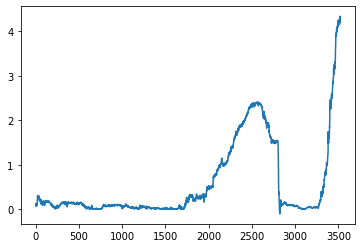

In [25]:
plt.plot(stock_data['^IRX']['Close'])

## Model

### XGBoost

#### APPLE

In [202]:
fromDate = "2010-01-01"
toDate = '2023-01-01'
stock = 'AAPL'
window_size = 250
lag = 5
starting_funds = 50000
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'

with SuppressFutureWarnings():
    xgboost_model = XGBoostModel(loss_fn)
    xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, lag=lag)
    xgboost_stock_predictor.fit_predict()
    xgboost_stock_predictor.print_metrics()

Processing: 100%|██████████| 3004/3004 [03:50<00:00, 13.06it/s]

Mean Squared Error (MSE): 4.3993
Root Mean Squared Error (RMSE): 2.0975
Mean Absolute Error (MAE): 1.4965


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


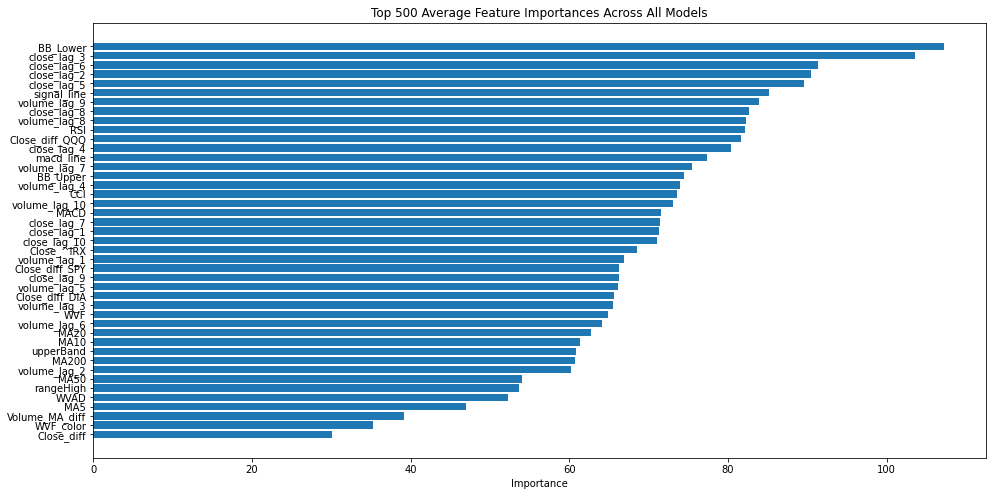

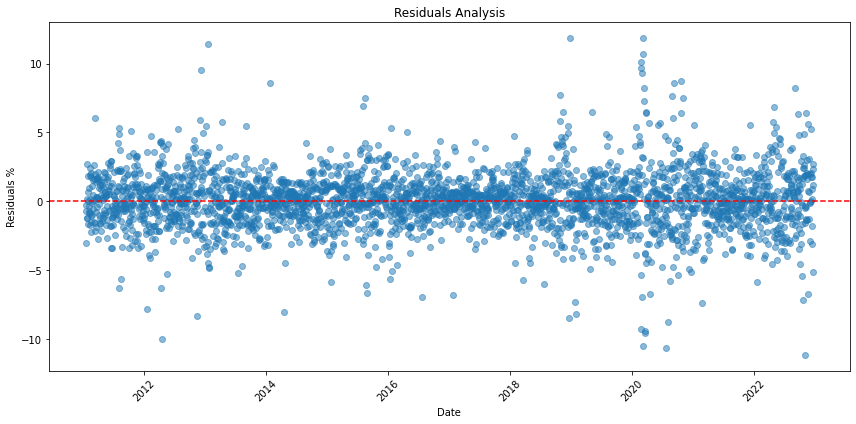

In [206]:
xgboost_stock_predictor.show_feature_importance(500)
xgboost_stock_predictor.plot_residuals()

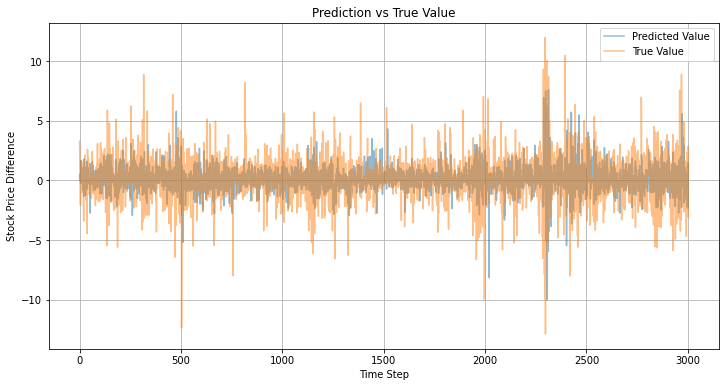

In [207]:
plt.figure(figsize=(12, 6))
plt.plot(xgboost_stock_predictor.predictions, label='Predicted Value', alpha=0.5)
plt.plot(xgboost_stock_predictor.true_values, label='True Value', alpha=0.5)  # Ensure y is also inversely transformed
plt.title(f'Prediction vs True Value')
plt.xlabel('Time Step')
plt.ylabel('Stock Price Difference')
plt.legend()
plt.grid(True)
plt.show()

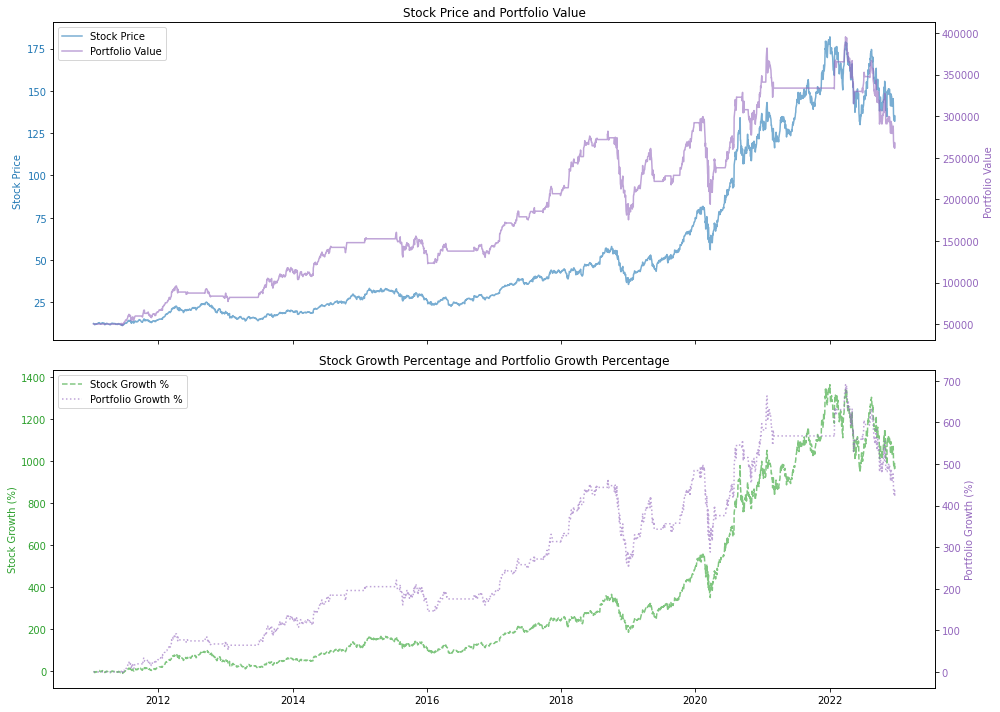

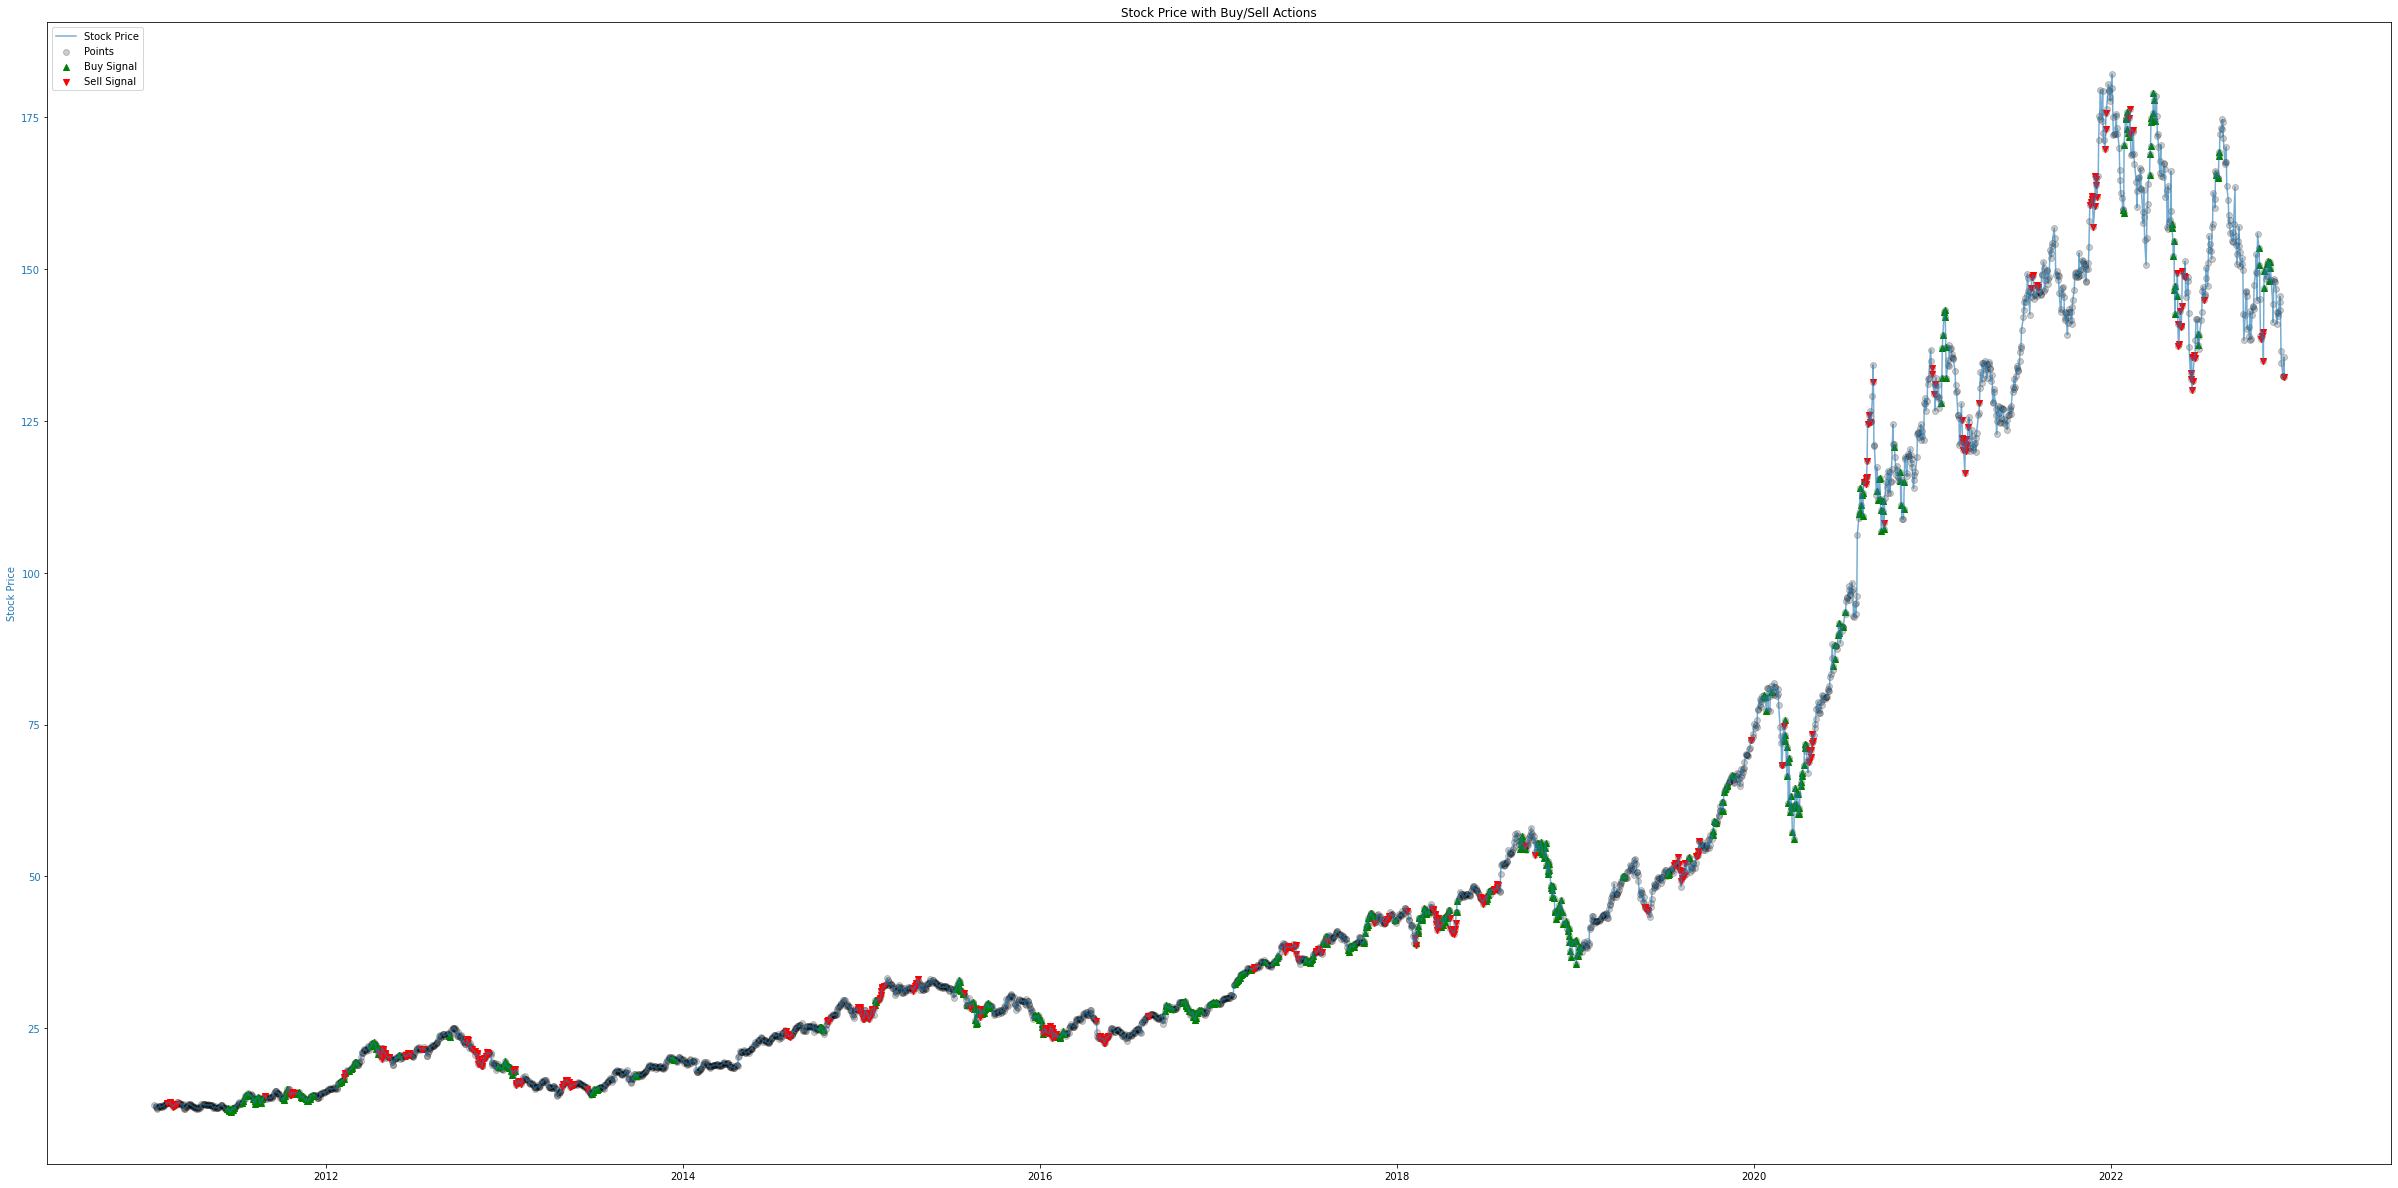

In [251]:
xgboost_stock_predictor.trading_strategy(window_size=window_size)

#### window size analysis 

In [13]:
fromDate = "2010-01-01"
toDate = '2023-01-01'
stock = 'AAPL'
window_sizes = [5, 20, 80, 160, 320, 640, 1280, 2560]
late = 5
starting_funds = 50000
loss_fn = 'reg:squarederror'  # 'reg:pseudohubererror'

mape_values = []

with SuppressFutureWarnings():
    xgboost_model = XGBoostModel(loss_fn)
    for window in window_sizes:
        xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window, lag=late)
        xgboost_stock_predictor.fit_predict()
        xgboost_stock_predictor.print_metrics()
        mape_values.append(xgboost_stock_predictor.MSE)

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing: 100%|██████████| 3249/3249 [01:53<00:00, 28.68it/s]


Mean Squared Error (MSE): 6.3340
Root Mean Squared Error (RMSE): 2.5168
Mean Absolute Error (MAE): 1.8048


Processing: 100%|██████████| 3234/3234 [02:12<00:00, 24.47it/s]


Mean Squared Error (MSE): 5.6032
Root Mean Squared Error (RMSE): 2.3671
Mean Absolute Error (MAE): 1.7034


Processing: 100%|██████████| 3174/3174 [02:30<00:00, 21.11it/s]


Mean Squared Error (MSE): 4.8002
Root Mean Squared Error (RMSE): 2.1909
Mean Absolute Error (MAE): 1.5596


Processing: 100%|██████████| 3094/3094 [02:56<00:00, 17.53it/s]


Mean Squared Error (MSE): 4.4835
Root Mean Squared Error (RMSE): 2.1174
Mean Absolute Error (MAE): 1.5142


Processing: 100%|██████████| 2934/2934 [04:18<00:00, 11.35it/s]


Mean Squared Error (MSE): 4.4226
Root Mean Squared Error (RMSE): 2.1030
Mean Absolute Error (MAE): 1.4947


Processing: 100%|██████████| 2614/2614 [06:51<00:00,  6.36it/s]


Mean Squared Error (MSE): 4.2989
Root Mean Squared Error (RMSE): 2.0734
Mean Absolute Error (MAE): 1.4691


Processing: 100%|██████████| 1974/1974 [08:41<00:00,  3.79it/s]


Mean Squared Error (MSE): 4.2859
Root Mean Squared Error (RMSE): 2.0702
Mean Absolute Error (MAE): 1.4941


Processing: 100%|██████████| 694/694 [04:50<00:00,  2.39it/s]

Mean Squared Error (MSE): 5.3002
Root Mean Squared Error (RMSE): 2.3022
Mean Absolute Error (MAE): 1.7478


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


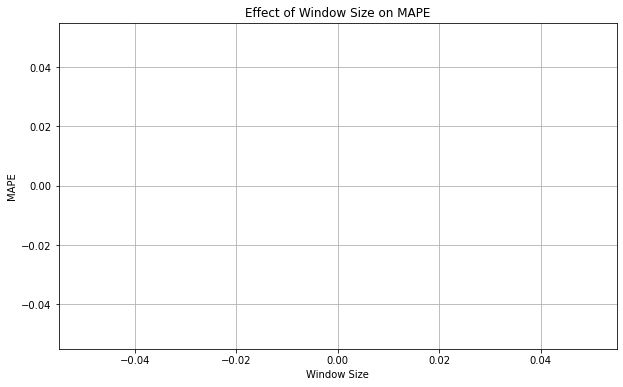

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(window_sizes[:len(mape_values)], mape_values, marker='o', linestyle='-')
plt.xlabel('Window Size')
plt.ylabel('MAPE')
plt.title('Effect of Window Size on MAPE')
plt.grid(True)
plt.show()

#### performance in various stocks

In [11]:
min_mape_value = min(mape_values)
optimal_window_size = window_sizes[mape_values.index(min_mape_value)]
for stock in ["TSLA", "AAPL", "MSFT", "AMZN", "GOOG"]:
    # fromDate = "2015-01-01"
    # toDate = '2017-01-01'
    fromDate = "2010-01-01"
    toDate = '2023-01-01'
    window_size = optimal_window_size
    late = 5
    starting_funds = 50000
    loss_fn = 'reg:squarederror' #'reg:pseudohubererror'

    with SuppressFutureWarnings():
        print(stock)
        xgboost_model = XGBoostModel(loss_fn)
        xgboost_stock_predictor = StockPredictor(stock_data, xgboost_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, late=late)
        xgboost_stock_predictor.fit_predict()
        xgboost_stock_predictor.print_metrics()
        print("==="*9)


c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'mape_values' is not defined

### Random Forest

### APPLE

In [92]:
fromDate = "2017-01-01"
toDate = '2023-01-01'
stock = 'AAPL'
window_size = 200
lag = 5
starting_funds = 50000
loss_fn = 'squared_error'

with SuppressFutureWarnings():  
    rf_model = RandomForest(loss_fn)
    rf_stock_predictor = StockPredictor(stock_data, rf_model, stock=stock, fromDate=fromDate, toDate=toDate, window_size=window_size, lag=lag)
    rf_stock_predictor.fit_predict()
    rf_stock_predictor.print_metrics()

Processing:   0%|          | 4/1295 [00:01<07:52,  2.73it/s]


KeyboardInterrupt: 

### LSTM, inspired by A deep learning framework for financial time series using stacked autoencoders and longshort term memory

In [177]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import helper

In [178]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, weight_decay):
        super(StockPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size) 
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.weight_decay = weight_decay 

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).detach()
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device).detach()
        
        out, _ = self.lstm(x, (h0, c0)) 
        
        # Apply dropout to the output of the LSTM
        out = self.dropout(out)
        
        # Apply batch norm to the output of the LSTM
        out = out.transpose(1, 2) 
        out = self.batchnorm(out)
        out = out.transpose(1, 2) 

        # Only take the output from the final timetep
        out = self.fc(out[:, -1, :])
        return out

    def train_test_model(self, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

        train_loss_history, test_loss_history = [], []
        best_test_loss = float('inf')
        
        for epoch in range(num_epochs):
            self.train()
            train_losses = []
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            
            scheduler.step()  # Adjust the learning rate based on the scheduler
            average_train_loss = np.mean(train_losses)
            
            self.eval()
            test_losses = []
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = self(inputs)
                    loss = criterion(outputs, targets)
                    test_losses.append(loss.item())
            average_test_loss = np.mean(test_losses)

            if average_test_loss < best_test_loss:
                best_test_loss = average_test_loss
                torch.save(self.state_dict(), 'best_model.pth')  # Save your model parameters

            train_loss_history.append(average_train_loss)
            test_loss_history.append(average_test_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}')
        
        return train_loss_history, test_loss_history
    

In [179]:
stock = 'AAPL'
sequence_length=200
prediction_length=5
df_stock = stock_data[stock]

df_stock = df_stock[['Date', 'Open', 'High', 'Low', 'Close', 'Close_diff', 'Volume_MA_diff', 
                 'MA5', 'MA10', 'MA20', 'MA50', 'MA200', 
                 'WVAD', 'MACD',  'RSI', 'macd_line', 'signal_line', 'CCI', 
                 'BB_Upper', 'BB_Lower', 'Buy_Signal', 'Sell_Signal', 
                 'WVF_color', 'WVF', 'upperBand', 'rangeHigh'
                 #'VPT', 'AD'
                ]] 

dataToAdd = ['^IRX', 'SPY', 'QQQ', 'DIA'] # 'QQQ', "SPY", "MSFT", "AMZN", "GOOG",'DIA'
for item in dataToAdd:
    if item != "^IRX":
        df_stock = df_stock.merge(stock_data[item][['Date', 'Close_diff']], on="Date", how='inner', suffixes=("", f'_{item}'))
    else:
        df_stock = df_stock.merge(stock_data[item][['Date', 'Close']], on="Date", how='inner', suffixes=("", f'_{item}'))
df_stock[f'Return_{prediction_length}_days_later'] = df_stock['Close_diff'].shift(-prediction_length)
df_stock['MACD'] = df_stock['macd_line'] - df_stock['signal_line']
for i in range(1, 11):  # range - 1 lag days
    df_stock[f'close_lag_{i}'] = df_stock['Close_diff'].shift(i)        
    df_stock[f'volume_lag_{i}'] = df_stock['Volume_MA_diff'].shift(i)
toDrop = ['Open', 'High', 'Low', 'Return_{}_days_later'.format(prediction_length), 'Close']
df_stock = df_stock.drop(toDrop, axis=1).dropna()

In [180]:
split_point = df_stock.index[df_stock['Date'] >= "2019-01-01"][0]

close_prices_Y = df_stock['Close_diff']
df_stock_swt = helper.apply_stationary_wavelet_transform(df_stock)
scaler_x = MinMaxScaler(feature_range=(0, 1))
df_stock_swt = scaler_x.fit_transform(df_stock_swt)

close_prices_Y = close_prices_Y.values.reshape(-1, 1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
close_prices_Y = scaler_y.fit_transform(close_prices_Y)

X, y = helper.create_sequences(df_stock_swt, close_prices_Y, sequence_length, prediction_length)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train_tensor = X_tensor[:split_point]
y_train_tensor = y_tensor[:split_point]
X_test_tensor = X_tensor[split_point:]
y_test_tensor = y_tensor[split_point:]

batch_size = 64
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

input_size = X.shape[2]

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Date is not numerical or is the target variable


In [182]:
input_size = input_size
hidden_size = 50
num_layers = 3
output_size = 1
dropout_prob = 0.2
weight_decay = 0.001
model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob, weight_decay).to(device)
train_loss_history, test_loss_history = model.train_test_model(train_loader, test_loader, num_epochs=50, learning_rate=0.001)

Epoch [1/50], Train Loss: 0.3750, Test Loss: 0.0257
Epoch [2/50], Train Loss: 0.1390, Test Loss: 0.1064
Epoch [3/50], Train Loss: 0.0557, Test Loss: 0.0100
Epoch [4/50], Train Loss: 0.0181, Test Loss: 0.0093
Epoch [5/50], Train Loss: 0.0108, Test Loss: 0.0084
Epoch [6/50], Train Loss: 0.0076, Test Loss: 0.0084
Epoch [7/50], Train Loss: 0.0059, Test Loss: 0.0084
Epoch [8/50], Train Loss: 0.0063, Test Loss: 0.0084
Epoch [9/50], Train Loss: 0.0056, Test Loss: 0.0084
Epoch [10/50], Train Loss: 0.0055, Test Loss: 0.0084
Epoch [11/50], Train Loss: 0.0058, Test Loss: 0.0084
Epoch [12/50], Train Loss: 0.0049, Test Loss: 0.0084
Epoch [13/50], Train Loss: 0.0048, Test Loss: 0.0084
Epoch [14/50], Train Loss: 0.0047, Test Loss: 0.0084
Epoch [15/50], Train Loss: 0.0046, Test Loss: 0.0084
Epoch [16/50], Train Loss: 0.0046, Test Loss: 0.0084
Epoch [17/50], Train Loss: 0.0044, Test Loss: 0.0084
Epoch [18/50], Train Loss: 0.0044, Test Loss: 0.0084
Epoch [19/50], Train Loss: 0.0045, Test Loss: 0.0084
Ep

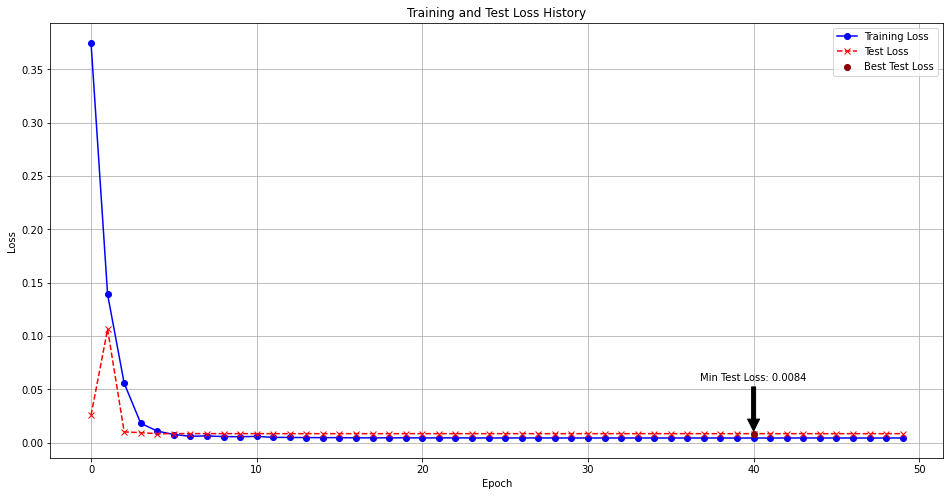

In [184]:
plt.figure(figsize=(16,8))
plt.plot(train_loss_history, label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(test_loss_history, label='Test Loss', color='red', linestyle='--', marker='x')

min_test_loss = min(test_loss_history)
min_test_loss_index = test_loss_history.index(min_test_loss)
plt.scatter(min_test_loss_index, min_test_loss, color='darkred', label='Best Test Loss', zorder=5)

plt.annotate(f'Min Test Loss: {min_test_loss:.4f}',
             xy=(min_test_loss_index, min_test_loss),
             xytext=(min_test_loss_index, min_test_loss + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluation

In [188]:
model = StockPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob, weight_decay)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

StockPriceLSTM(
  (lstm): LSTM(90, 50, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [189]:
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
model.eval()
predictions = []
with torch.no_grad():
    for window in X_tensor:
        window = window.unsqueeze(0)  # Add batch dimension
        prediction = model(window)
        predictions.append(prediction.cpu().numpy())

predictions = np.array(predictions).squeeze()

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


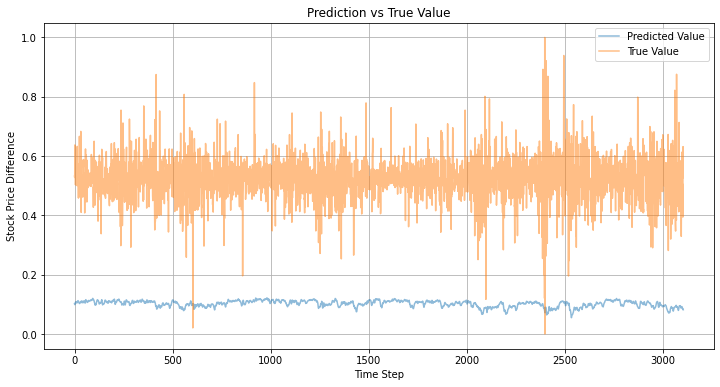

In [195]:
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted Value', alpha=0.5)
plt.plot(y, label='True Value', alpha=0.5)  # Ensure y is also inversely transformed
plt.title(f'Prediction vs True Value')
plt.xlabel('Time Step')
plt.ylabel('Stock Price Difference')
plt.legend()
plt.grid(True)
plt.show()

## other